In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm
from numpy.linalg import norm

## for higher order the coefficients are of order 10^24/10^28
B_sign = {3: (np.array([-1,0,1]),2), # Accuracy is O(h^2)
          5: (np.array([1,-8,0,8,-1]),12), # Accuracy is O(h^4)
          7: (np.array([-1,9,-45,0,45,-9,1]),60), # Accuracy is O(h^6)
          9: (np.array([3,-32,168,-672,0,672,-168,32,-3]),840), # Accuracy is O(h^8)
          11: (np.array([-2,25,-150,600,-2100,0,2100,-600,150,-25,2]),2520)} # Accuracy is O(h^10)

def speed_multiple(b,c_map):
    """Multiply each column of a matrix by given constant."""
    for j, c in enumerate(c_map):
        b[:,j] *= c
    return b

def make_B(N, coefs, cbase):
    """ make matrix B s.t. L = -BB.T with correct zero boundary conditions.
    N - size of B.
    coefs - list of coefficients.
    cbase - divider.
    
    """
    B = np.zeros((N,N))
    l = len(coefs)//2
    diags = list(range(-l,l+1))
    for i,val in zip(diags,coefs):
        B += val*np.eye(N,k=i)

    ### Boundary connditions
    ## left side
    B[0,:] = np.zeros_like(B[0,:])
    B[:,0] = np.zeros_like(B[:,0])
    
    for i in range(l):
        coef_temp = coefs[-(i+1):]
        B[l-i,:len(coef_temp)] = B[l-i,:len(coef_temp)] - coef_temp
        # print(l-i, coef_temp)
    B[:,0] = B[:,0]*np.sqrt(2)

    ## right side
    B[-1,:] = np.zeros_like(B[-1,:])
    B[:,-1] = np.zeros_like(B[:,-1])
    for i in range(l):
        coef_temp = coefs[:(i+1)]
        B[-(l-i)-1,-len(coef_temp):] = B[-(l-i)-1,-len(coef_temp):] - coef_temp
        # print(-(l-i)-1, coef_temp)
    B[:,-1] = B[:,-1]*np.sqrt(2)
    
    # return B
    return B/cbase


def get_B_H_expmH(acc_order, nq, t, dx, c_map):
    """
    Parameters:
    acc_order - accuracy order for spce derivative,
    nq - number of qubits used for matix B, i.e. total number minus 1.
    t - time from expm(-iHt/dx),
    dx - space step from expm(-iHt/dx).
    c_map - speed coeficients.
    
    Returns:
    B - matrix B, i.e. matrix for finite deffiernce scheme,
    H - Hamiltonian composed of matrix B and B transposed (since all entries are real),
    expm_H - expm(-iHt/dx) computed directly.
    """
    n_points = der_acc_order + 1
    coef_B,cb_B = B_sign[n_points]
    B = make_B(2**(nq),coef_B,cb_B)
    B = speed_multiple(B, c_map)
    H = np.block([[np.zeros_like(B), B],[B.T, np.zeros_like(B)]])
    expm_H = expm(-1j*H*t/dx)
    return B, H, expm_H

In [2]:
"""Parameters"""
l = 5
t = 1
# p = 2 # Trotter formula order
A = 1
c_max = 1

der_acc_order_list = [2,4,6,8,10] # space derivative accuracy order
NQ_list = [5,6,7,8] # Total number of qubits

norm_H_n = []
for NQ in NQ_list:
    nq = NQ - 1
    x_real = np.linspace(0,l,2**(nq))
    dx = x_real[1]-x_real[0]
    c_map_list = [c_max]*2**(nq)
    norm_H_k = []
    for der_acc_order in der_acc_order_list:
        _, H, expm_H = get_B_H_expmH(der_acc_order, nq, t, dx, c_map_list)
        norm_H_k.append(norm(H, ord=2))
    norm_H_n.append(norm_H_k)

norm_H_n_arr_T = np.array(norm_H_n).T
norm_H_n_arr = np.array(norm_H_n)

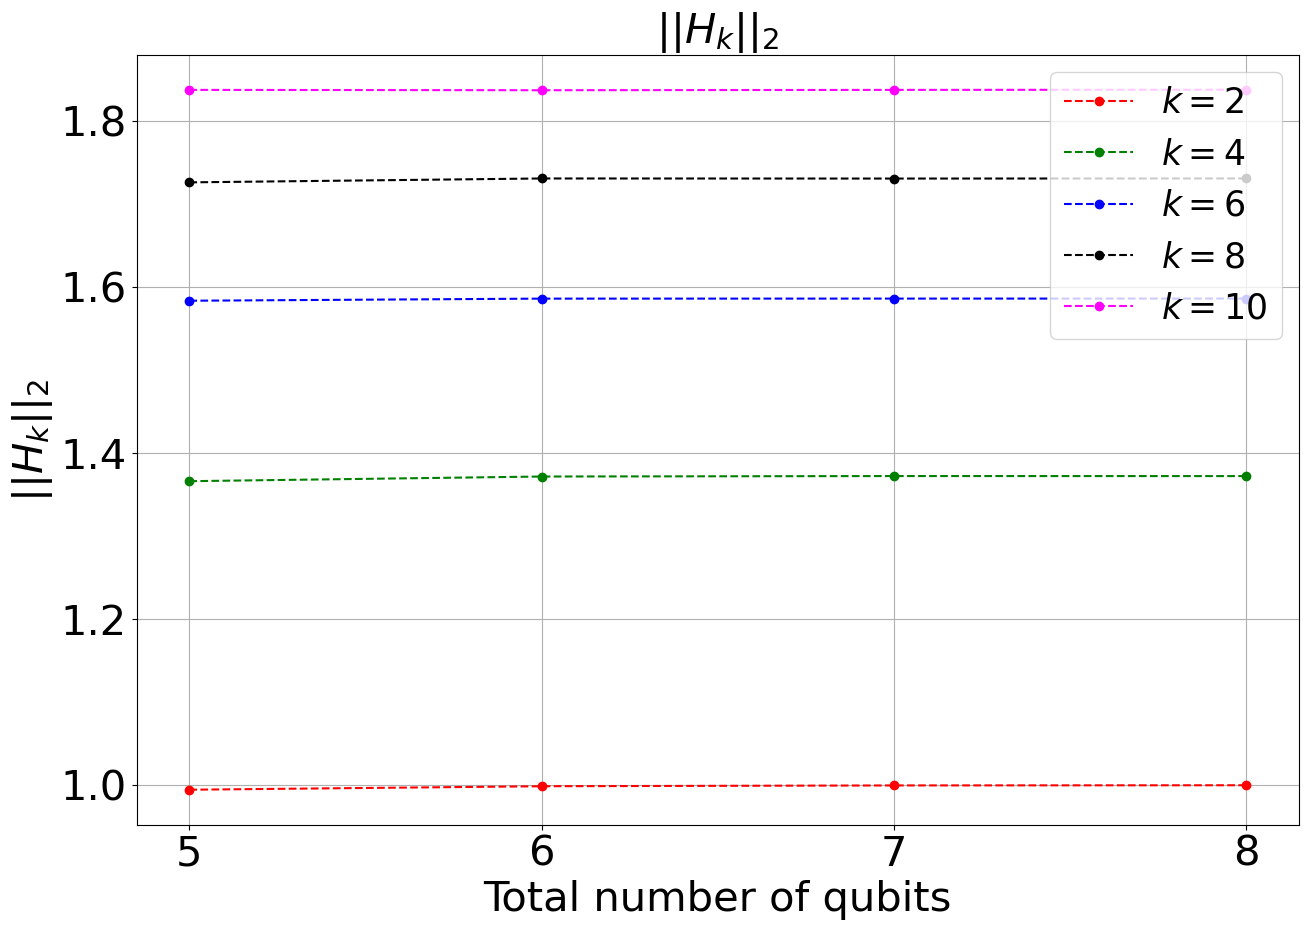

In [3]:
plt.figure(figsize = (15,10))
colour_list = ['r','g','b','black','magenta']

for der_acc_order, norm_H_n, c in zip(der_acc_order_list ,norm_H_n_arr_T, colour_list):
    plt.plot(NQ_list, norm_H_n, marker='o', c=c,
             linestyle='dashed',label='$k = {}$'.format(der_acc_order))


# plt.yscale('log')
# plt.xscale('log')
plt.grid(alpha = 1)
plt.legend(loc='upper right',fontsize = 25)
plt.title('$||H_k||_2$', fontsize = 30)
plt.xlabel('Total number of qubits', fontsize = 30 )
plt.ylabel('$||H_k||_2$', fontsize = 30 )
plt.xticks(NQ_list)

plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)  

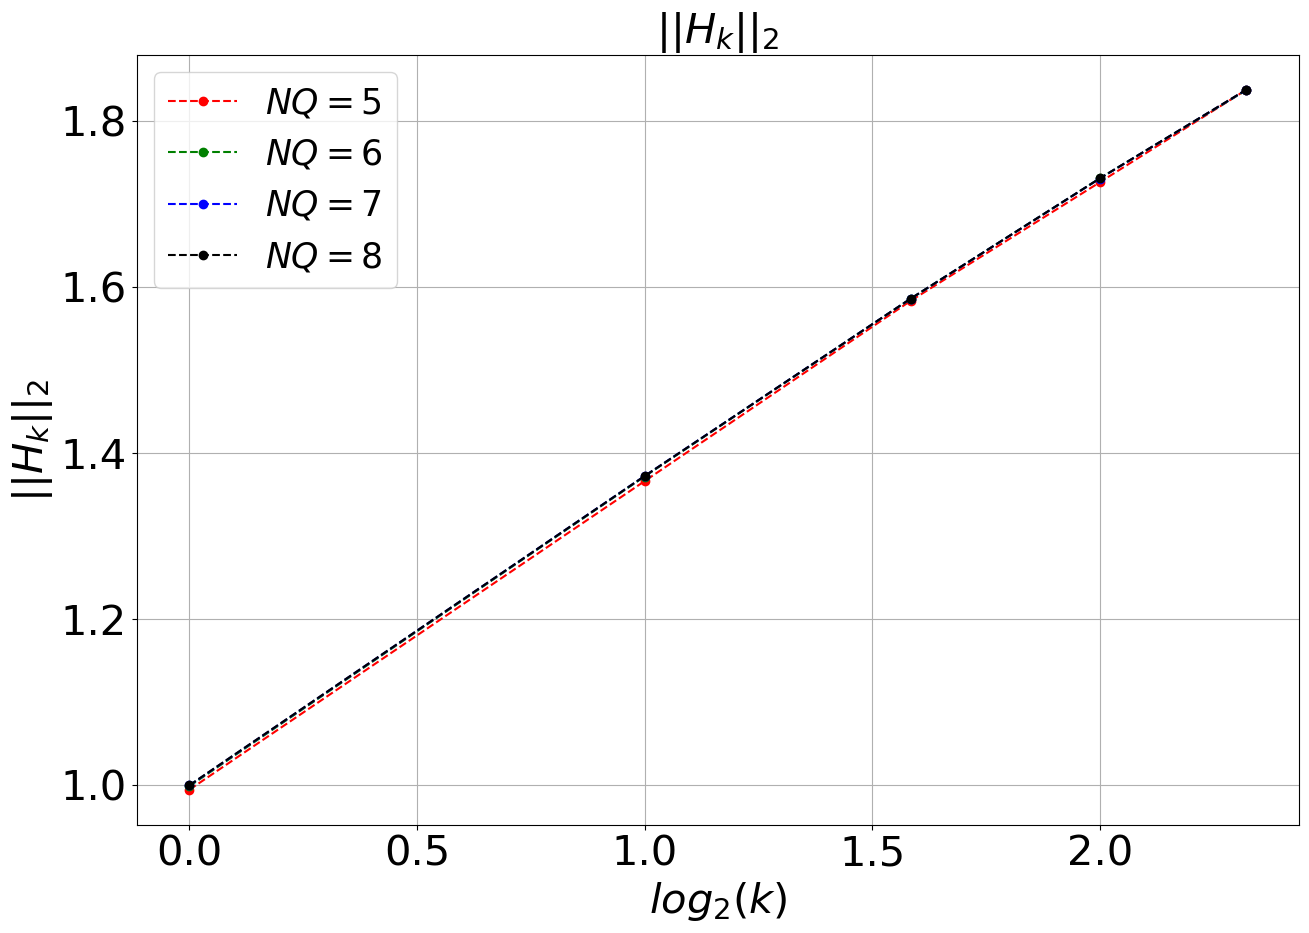

In [15]:
plt.figure(figsize = (15,10))
colour_list = ['r','g','b','black']

for NQ, norm_H_k, c in zip(NQ_list ,norm_H_n_arr, colour_list):
    # print(NQ, norm_H_k)
    plt.plot(np.log2(np.array(der_acc_order_list)/2), norm_H_k, marker='o', c=c,
             linestyle='dashed',label='$NQ = {}$'.format(NQ))


# plt.xscale('log')
plt.grid(alpha = 1)
plt.legend(fontsize = 25)
plt.title('$||H_k||_2$', fontsize = 30)
plt.xlabel('$log_2(k)$', fontsize = 30 )
plt.ylabel('$||H_k||_2$', fontsize = 30 )
# plt.xticks(der_acc_order_list)

plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)